In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import csv
import pandas as pd
import seaborn as sns
import json

import glob

from pygmo import hypervolume

In [3]:
from pathlib import Path

In [4]:
upper_level_path = Path('../')

In [5]:
results_glob_pattern = './random_logs/*'

In [6]:
results_dirs_tt = list(upper_level_path.glob(results_glob_pattern))

In [7]:
#results_dirs_tt = glob.glob(results_glob_pattern)
results_dirs_tt

[WindowsPath('../random_logs/.ipynb_checkpoints'),
 WindowsPath('../random_logs/2019-01-23_06-48-03'),
 WindowsPath('../random_logs/2019-01-23_06-49-19')]

In [8]:
def get_objectives(dir_name):
    objectives = []
    
    try:
        with open(dir_name / 'opt-mode.txt', 'r') as optmode_f:
            optmode = optmode_f.read()
            
        with open(dir_name / 'test_fits.csv') as test_f,\
            open(dir_name / 'train_fits.csv') as train_f,\
            open(dir_name / 'train_battery_context_switches.csv') as train_b,\
            open(dir_name / 'test_battery_context_switches.csv') as test_b,\
            open(dir_name / 'test_max_peaks.csv') as test_mp,\
            open(dir_name / 'train_max_peaks.csv') as train_mp:
                test_f_reader = csv.DictReader(test_f, delimiter=';')
                train_f_reader = csv.DictReader(train_f, delimiter=';')
                train_b_reader = csv.DictReader(train_b, delimiter=';')
                test_b_reader = csv.DictReader(test_b, delimiter=';')
                test_mp_reader = csv.DictReader(test_mp, delimiter=';')
                train_mp_reader = csv.DictReader(train_mp, delimiter=';')

                reader_iterator = zip(test_f_reader,
                                      train_f_reader,
                                      test_b_reader,
                                      train_b_reader,
                                      test_mp_reader,
                                      train_mp_reader)

                for tef, trf, teb, trb, temp, trmp in reader_iterator:
                    te_instance = (
                        tef["individual_id"],
                        eval(tef["fitness"])[0],
                        eval(tef["fitness"])[1],
                        float(temp["max_peak"]),
                        int(teb["battery_context_switches"]),
                        'test',
                        optmode)

                    tr_instance = (
                        trf["individual_id"],
                        eval(trf["fitness"])[0],
                        eval(trf["fitness"])[1],
                        float(trmp["max_peak"]),
                        int(trb["battery_context_switches"]),
                        'train',
                        optmode)

                    objectives.extend([te_instance, tr_instance])
    except FileNotFoundError as e:
        print(f"File not found, skipping {dir_name}")
        print(e)
    return objectives

In [9]:
def get_objectives_df(dir_name, run_id):
    df = pd.DataFrame(get_objectives(dir_name),
                      columns="id cost green max_peak battery_context_switches train_test optimization_mode".split())
    df["run_id"] = run_id
    return df

In [10]:
results_tt_dfs = [get_objectives_df(dir_name, dir_name.parts[1]+dir_name.parts[-1]) for dir_name in results_dirs_tt]
results_tt_df_concat = pd.concat(results_tt_dfs, ignore_index=True)

File not found, skipping ..\random_logs\.ipynb_checkpoints
[Errno 2] No such file or directory: '..\\random_logs\\.ipynb_checkpoints\\opt-mode.txt'


In [11]:
results_tt_df_concat.head()

id       cost      green  max_peak  \
0  132844d1-7f6e-43a2-9327-3be40ed633fd  -3.005856  31.043962  1.424016   
1  132844d1-7f6e-43a2-9327-3be40ed633fd -25.504012  25.343454  1.303215   
2  e36d9104-d3af-4159-ada7-6b45f4563c36 -12.160962  30.454509  1.520417   
3  e36d9104-d3af-4159-ada7-6b45f4563c36 -34.478391  25.296764  1.520417   
4  cea51c96-e88a-4ad8-a0f1-c8e731409d64 -11.650794  32.082141  1.520417   

  battery_context_switches train_test optimization_mode  \
0                      219       test            NSGAII   
1                      227      train            NSGAII   
2                      217       test            NSGAII   
3                      229      train            NSGAII   
4                      201       test            NSGAII   

                           run_id  
0  random_logs2019-01-23_06-48-03  
1  random_logs2019-01-23_06-48-03  
2  random_logs2019-01-23_06-48-03  
3  random_logs2019-01-23_06-48-03  
4  random_logs2019-01-23_06-48-03

In [12]:
results_tt_df_concat['is_optimal'] = results_tt_df_concat["run_id"].str.startswith("optimal")

In [13]:
results_tt_df_train_test = results_tt_df_concat.drop(results_tt_df_concat.index[(results_tt_df_concat["run_id"].str.contains('optimal')) & (results_tt_df_concat["train_test"] == "test")])
results_tt_df_train_test.loc[results_tt_df_train_test['run_id'].str.contains('train')].groupby(by="train_test").count()

Empty DataFrame
Columns: [id, cost, green, max_peak, battery_context_switches, optimization_mode, run_id, is_optimal]
Index: []

In [14]:
results_tt_df_train_test.loc[1]

id                          132844d1-7f6e-43a2-9327-3be40ed633fd
cost                                                     -25.504
green                                                    25.3435
max_peak                                                 1.30321
battery_context_switches                                     227
train_test                                                 train
optimization_mode                                         NSGAII
run_id                            random_logs2019-01-23_06-48-03
is_optimal                                                 False
Name: 1, dtype: object

In [15]:
results_tt_df = results_tt_df_train_test.copy()
results_tt_df.loc[results_tt_df['run_id'].str.contains('test'),'train_test'] = "test"
results_tt_df.loc[results_tt_df["run_id"].str.startswith("optimal"), 'run_id'] = "optimal"

In [16]:
#sns.lmplot("cost", "green", results_tt_df, hue="train_test", fit_reg=False, row="run_id");
#fig = plt.gcf()

In [17]:
#sns.lmplot("cost", "green", results_tt_df,
#           hue="optimization_mode", fit_reg=False, col="train_test",
#           scatter_kws=dict(alpha=0.4), hue_order=["GP", "NSGAII"]);
#plt.savefig('gp-vs-tt_expression_power.png');

In [18]:
#sns.catplot(x="cost", y="run_id",
#                 hue="optimization_mode", col="train_test",
#                 data=results_tt_df, kind="boxen");
#plt.savefig('gp-vs-tt_expression_power-cost.png');

#sns.catplot(x="green", y="run_id",
#                 hue="optimization_mode", col="train_test",
#                 data=results_tt_df, kind="boxen");
#plt.savefig('gp-vs-tt_expression_power-green.png');

#sns.catplot(x="max_peak", y="run_id",
#                hue="optimization_mode", col="train_test",
#                 data=results_tt_df, kind="boxen");
#plt.savefig('gp-vs-tt_expression_power-max_peak.png');

#sns.catplot(x="battery_context_switches", y="run_id",
#                 hue="optimization_mode", col="train_test",
#                 data=results_tt_df, kind="boxen");
#plt.savefig('gp-vs-tt_expression_power-battery_context_switches.png');

In [57]:
#plt.rc('font', family='serif')
plt.rc('text', usetex=False)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=24)

MARKER_SIZE = 3
LEGEND_TEXT_SIZE = 12
LEGEND_MARKER_SIZE = 8

In [58]:
def plot_predefined_routines_results(path, train_test):
    predefined_routines_names_mapping = {
        "use_grid_first": "Battery-first strategy",
        "use_battery_first": "Grid-first strategy",
        "use_oportunist_sell": "Opportunist sell strategy",
    }
    with open(path, 'r') as prrf:
        predefined_routines_results = json.loads(prrf.read())
    for key, val in predefined_routines_results.items():
        cost, green = val.get(train_test).get('fitnes')
        plt.plot(cost, 100-green, 'D', label=predefined_routines_names_mapping.get(key), markersize=3*MARKER_SIZE)

In [61]:
#sns.lmplot("cost", "green", results_tt_df,
#           hue="train_test", fit_reg=False,
#           scatter_kws=dict(alpha=0.4));
def plot_final_populations(df, test_train, title=None, plot_label=None, plot_optimal=True, legend_loc="best", ylim=None):
    if plot_label is None:
        plot_label = ''
    subdf = df[df['train_test']==test_train]
    is_gp_not_optimal = (subdf["optimization_mode"] == "GP") & (subdf["is_optimal"] == False)
    is_tt_not_optimal = (subdf["optimization_mode"] == "NSGAII") & (subdf["is_optimal"] == False)
    is_optimal = subdf["is_optimal"]

    def get_bool_indexed(df, bool_index, x, y):
        return df.loc[bool_index, x], 100 - df.loc[bool_index, y]


    plt.figure(figsize=(6,6))
    if plot_optimal:
        plt.plot(*get_bool_indexed(subdf, is_optimal, 'cost', 'green'), 'o', label="Near-optimal strategy", markersize=MARKER_SIZE)
    else:
        plt.plot([],[])
    plt.plot(*get_bool_indexed(subdf, is_gp_not_optimal, 'cost', 'green'), 'o', label="Tree-based strategy", markersize=MARKER_SIZE)
    plt.plot([],[])
    plt.plot(*get_bool_indexed(subdf, is_tt_not_optimal, 'cost', 'green'), 'o', label="Timetable-based strategy", markersize=MARKER_SIZE)
    #plot_predefined_routines_results(results_dirs_tt[1] / 'predefined_routines_results.json', test_train)

    legend = plt.legend(loc=legend_loc, prop={'size': LEGEND_TEXT_SIZE})
    for lh in legend.legendHandles:
        lh._legmarker.set_markersize(LEGEND_MARKER_SIZE)
    #legend.legendHandles[0]._legmarker.set_markersize(LEGEND_MARKER_SIZE)
    #legend.legendHandles[1]._legmarker.set_markersize(LEGEND_MARKER_SIZE)
    
    if title is not None:
        plt.title(title)
    plt.xlabel('Cost');
    plt.ylabel('Green');
    #plt.xlim([-65, 0]);
    if ylim is not None:
        plt.ylim(ylim)
    # Hide the right and top spines
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.tight_layout()
    figure_name = 'output/{0}-{1}-optimal-gp-tt-predefined'.format(test_train, plot_label).replace('--', '-')
    plt.savefig(figure_name + '.pdf')
    plt.savefig(figure_name + '.png')

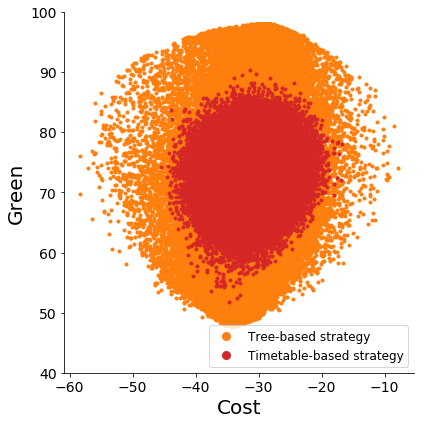

In [62]:
plot_final_populations(results_tt_df, "train", plot_label="random", plot_optimal=False, legend_loc="lower right", ylim=[40, 100])

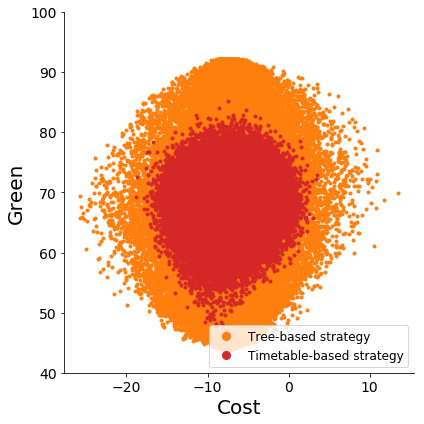

In [63]:
plot_final_populations(results_tt_df, "test", plot_label="random", plot_optimal=False, legend_loc="lower right", ylim=[40, 100])

# Pareto fronts

In [58]:
import pygmo

In [59]:
optimal_train_ids = {}
non_dominated_list = []
for group_id, group in results_tt_df.groupby(by=['is_optimal', 'optimization_mode', 'train_test', 'run_id']):
    if group_id[0] or group_id[2] == "train":
        non_dominated_idxs = pygmo.non_dominated_front_2d(points=group[["cost", "green"]].values)
        non_dominated_group = group.iloc[non_dominated_idxs]
        optimal_train_ids[group_id[3]] = non_dominated_group['id']
        non_dominated_list.append(non_dominated_group)

for group_id, group in results_tt_df.groupby(by=['is_optimal', 'optimization_mode', 'train_test', 'run_id']):
    if group_id[2] == "test" and not group_id[0]:
        non_dominated_group = group[group["id"].isin(optimal_train_ids[group_id[3]])]
        non_dominated_list.append(non_dominated_group)

non_dominated_df = pd.concat(non_dominated_list)

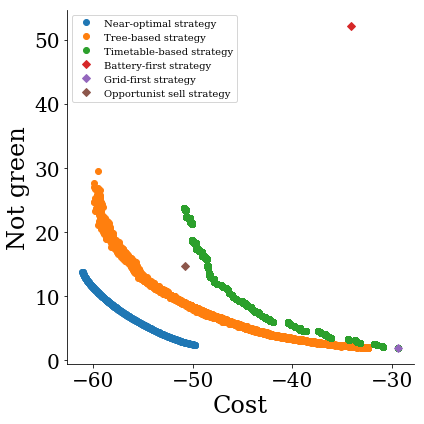

In [60]:
plot_final_populations(non_dominated_df, "train")

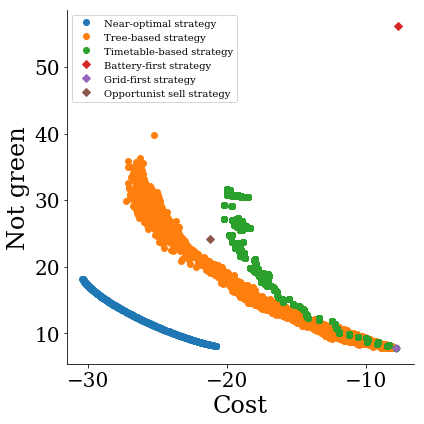

In [61]:
plot_final_populations(non_dominated_df, "test")

# Hypervolume

In [27]:
def get_generations_pop_log(fp):
    generations = []
    with open(fp, 'r') as ff:
        for line in ff:
            ind_json = json.loads(line)
            ind = (
                ind_json.get("uuid"),
                ind_json.get("fitness")[0],
                ind_json.get("fitness")[1],
                ind_json.get("max_peak"),
                ind_json.get("battery_context_switches"),
                ind_json.get("gen"),
            )
            generations.append(ind)
    return generations

In [28]:
def get_generations_pop_log_df(fp):
    if fp is None:
        return None
    df = pd.DataFrame(get_generations_pop_log(fp),
                      columns="id cost green max_peak battery_context_switches gen".split())
    df["run_id"] = fp.parts[-2]
    return df

In [29]:
def get_hvs(fp, ref_point=None):
    if fp is None:
        return None
    gen_df = get_generations_pop_log_df(fp)
    
    if ref_point is None:
        print("Reference point will be computed from the data.")
        ref_point_coef = np.sign(gen_df[["cost", "green"]].max().values) * 0.1 + 1
        ref_point = ref_point_coef * gen_df[["cost", "green"]].max().values
    grouped = gen_df.groupby('gen')
    hvs = []
    for i, group in grouped:
        fits = group[["cost", "green"]]
        hvs.append((i,
                   hypervolume(fits.values).compute(ref_point)))
    return hvs

In [30]:
def get_hvs_df(fp, ref_point=None):
    hvs = get_hvs(fp, ref_point)
    
    hvs_df = pd.DataFrame(hvs, columns="gen hv".split())
    hvs_df["run_id"] = fp.parts[-2]
    return hvs_df

In [31]:
def compute_ref_point(df):
    ref_point_coef = np.sign(df[["cost", "green"]].max().values) * 0.1 + 1
    ref_point = ref_point_coef * df[["cost", "green"]].max().values
    return ref_point

In [32]:
def get_log_file(result_dir):
    if 'optimal-test' in str(result_dir):
        print("Skipping, because it is a test dir {}".format(result_dir))
    else:
        found = list(result_dir.glob('logIndividualsPopulation*'))
        if found:
            print("Found {}".format(found[0]))
            return found[0]
        else:
            print("No logIndividualsPopulation in {}".format(result_dir))

In [33]:
def get_all_hvs(result_dirs):
    
    all_pop_logs_df = pd.concat([get_generations_pop_log_df(get_log_file(fp)) for fp in result_dirs])
    all_grouped = all_pop_logs_df.groupby(by=["run_id", 'gen'])
    all_grouped_ref_point = compute_ref_point(all_pop_logs_df)
    hvs = []
    for i, group in all_grouped:
        run_id, gen = i
        fits = group[["cost", "green"]]
        hv = (run_id,
              gen,
              hypervolume(fits.values).compute(all_grouped_ref_point))
        hvs.append(hv)
        
    hvs_df = pd.DataFrame(hvs,
                          columns="run_id gen hv".split())
    return hvs_df

In [34]:
#hvs_df = get_all_hvs(results_dirs_tt)
#hvs_df.to_csv("all_hvs.csv")
hvs_df = pd.read_csv("all_hvs.csv", index_col=0)

In [35]:
hvs_df.head()

run_id  gen           hv
0  2018-12-19_11-01-27    0  2084.725590
1  2018-12-19_11-01-27    1  2281.269920
2  2018-12-19_11-01-27    2  2327.986271
3  2018-12-19_11-01-27    3  2345.888496
4  2018-12-19_11-01-27    4  2369.875289

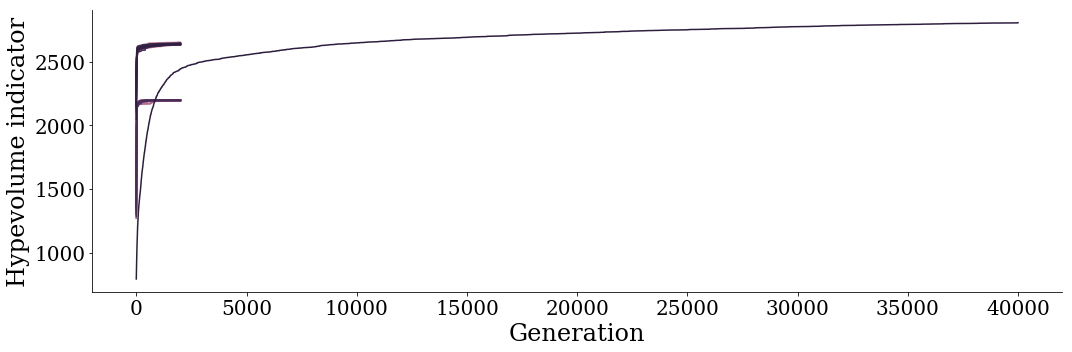

In [36]:
different_ids = len(pd.unique(hvs_df["run_id"]))
sns.relplot(x="gen", y="hv",
            data=hvs_df, hue="run_id",
            legend=False, kind="line", palette=sns.cubehelix_palette(different_ids), height=5, aspect=3);
plt.xlabel('Generation');
plt.ylabel('Hypevolume indicator');

In [37]:
hvs_df['evolution_progress'] = None
for group_id, group in hvs_df.groupby(by=["run_id"]):
    group.loc[:,"evolution_progress"] = group["gen"] / group.gen.max()
    hvs_df.loc[group.index.to_list(),"evolution_progress"] = group.evolution_progress

C:\Users\jernejz\Miniconda3\envs\jupyter\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
optimization_types_mapping = {}
optimization_types_dir_names_mapping = {
    "gp-logs-2018": "Tree-based strategy optimization",
    "optimal-train-40000": "Near-optimal strategy optimization (train)",
    "optimal-test-40000": "Near-opttimal strategy optimization (test)",
    "timetable-logs-2018": "Timetable-based strategy optimization",
}
for path in results_dirs_tt:
    optimization_types_mapping[path.parts[-1]] = optimization_types_dir_names_mapping.get(path.parts[1])

In [39]:
hvs_df["optimization_type"] = hvs_df.run_id.apply(lambda x: optimization_types_mapping[x])

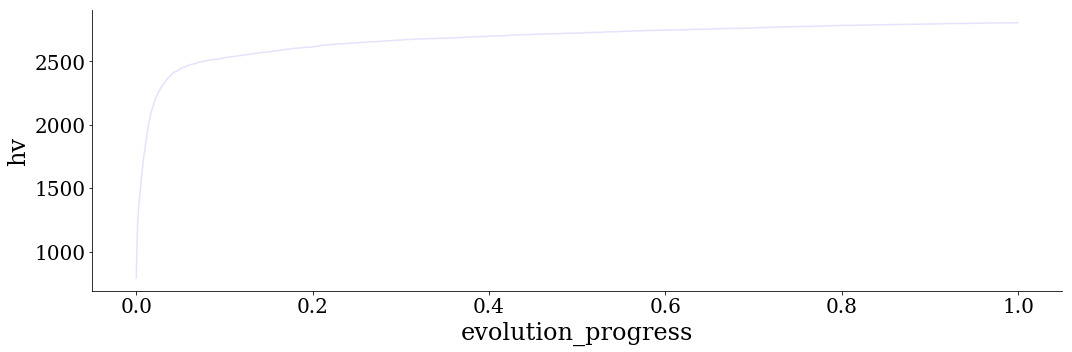

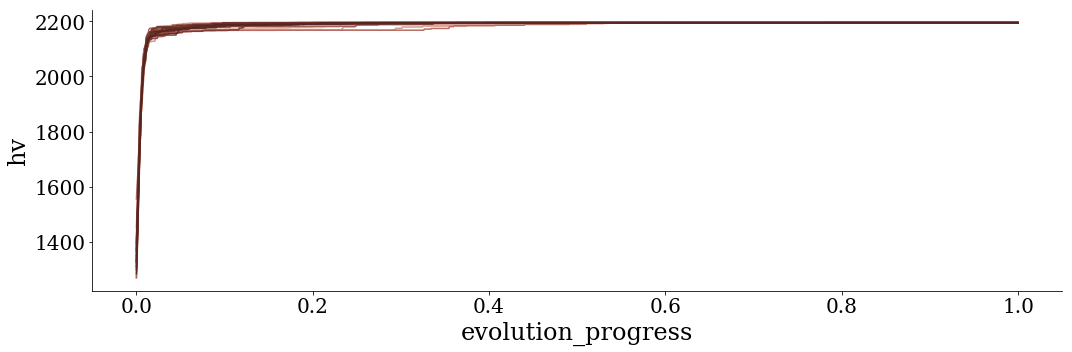

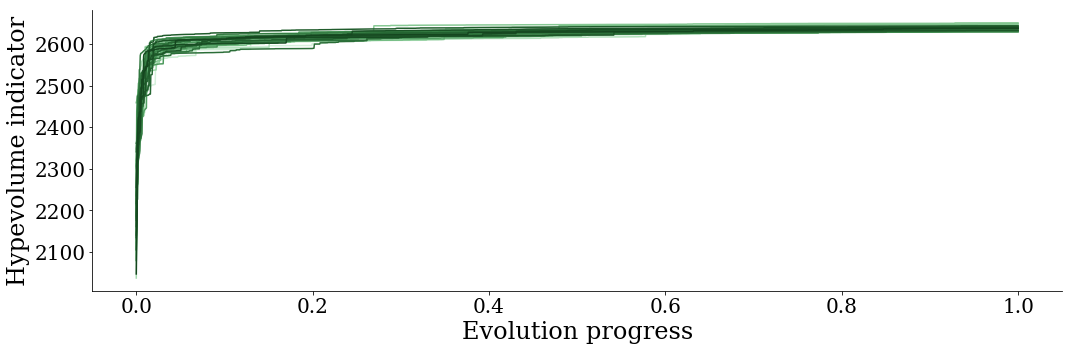

In [40]:
i = 0
for group_id, group in hvs_df.groupby('optimization_type'):
    different_ids = len(pd.unique(group["run_id"]))
    sns.relplot(x="evolution_progress", y="hv",
                data=group, hue="run_id", kind="line",
                palette=sns.cubehelix_palette(different_ids, start=i*1, rot=0., gamma=1., hue=1., light=0.9, dark=0.2),
                height=5, aspect=3, legend=False);
    i += 1
plt.xlabel('Evolution progress');
plt.ylabel('Hypevolume indicator');

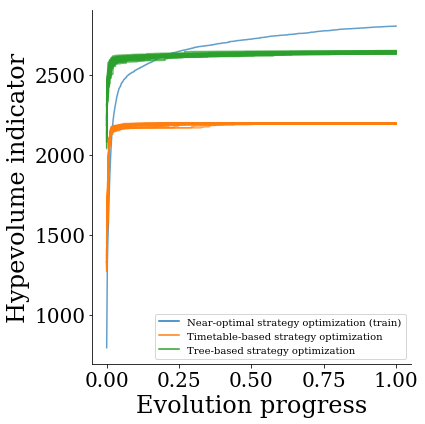

In [54]:
plt.figure(figsize=(6,6))

group_i_colors = {}
for group_i, (group_id, group) in enumerate(hvs_df.groupby('optimization_type')):
    for subgroup_i, (subgroup_id, subgroup) in enumerate(group.groupby('run_id')):
        p = plt.plot(subgroup["evolution_progress"].values, subgroup["hv"].values, color=group_i_colors.get(group_id), alpha=0.7)
        group_i_colors[group_id] = p[0].get_color()
        
for group_id, group_i_color in group_i_colors.items():
    plt.plot([],[], color=group_i_color, label=group_id)
    
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.xlabel('Evolution progress');
plt.ylabel('Hypevolume indicator');
plt.legend();
plt.tight_layout();
plt.savefig("./output/results-analysis-hv.pdf")

In [48]:
group_i_colors

{0: '#1f77b4', 1: '#ff7f0e', 2: '#2ca02c'}

In [21]:
def get_all_data_df(result_dirs):
    all_pop_logs_df = pd.concat([get_generations_pop_log_df(fp + '/logIndividualsPopulation.db') for fp in result_dirs])
    return all_pop_logs_df

In [22]:
generations_pop_df = get_all_data_df(results_dirs_tt)

In [23]:
generations_pop_df.head()

id       cost      green  max_peak  \
0  e0455dc6-ca82-4286-9ff1-3e66b114983c -31.423892  26.676183  1.520417   
1  7cf63219-54f3-44c5-8cc6-fe0502e7dcae -29.287866  25.728491  1.520417   
2  834d6e31-9c4b-4d49-b325-6544b289089b -32.183328  25.720919  1.520417   
3  807e3029-0bee-4242-98ce-2feeab24877a -30.996600  26.082742  1.520417   
4  95017cb9-59dc-4df3-b192-ed215566733e -29.819338  27.038193  1.520417   

   battery_context_switches  gen               run_id  
0                       223    0  2019-03-20_07-26-10  
1                       223    0  2019-03-20_07-26-10  
2                       231    0  2019-03-20_07-26-10  
3                       209    0  2019-03-20_07-26-10  
4                       227    0  2019-03-20_07-26-10

In [24]:
prepend_name = 'optimal_using-34927474367_'

/home/jernejz/miniconda3/envs/jupyter/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


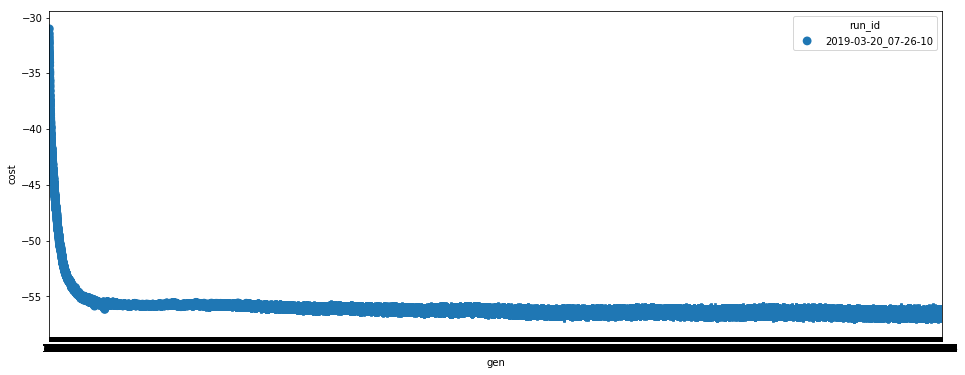

In [25]:
fig = plt.figure(figsize=(16,6))
on_x = 'gen'
on_y = 'cost'
sns.pointplot(x=on_x, y=on_y, data=generations_pop_df, hue="run_id", estimator=np.median, dodge=True);
plt.savefig(prepend_name + f'{on_x}-{on_y}.pdf');

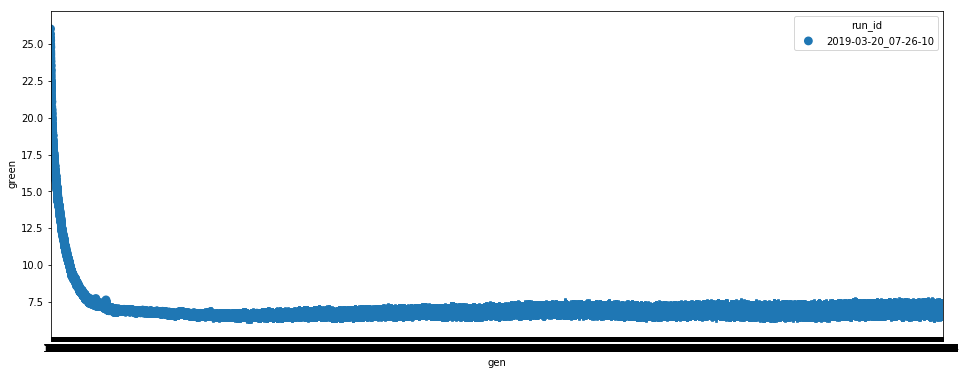

In [26]:
fig = plt.figure(figsize=(16,6))
on_x = 'gen'
on_y = 'green'
sns.pointplot(x=on_x, y=on_y, data=generations_pop_df, hue="run_id", estimator=np.median, dodge=True);
plt.savefig(prepend_name + f'{on_x}-{on_y}.pdf');

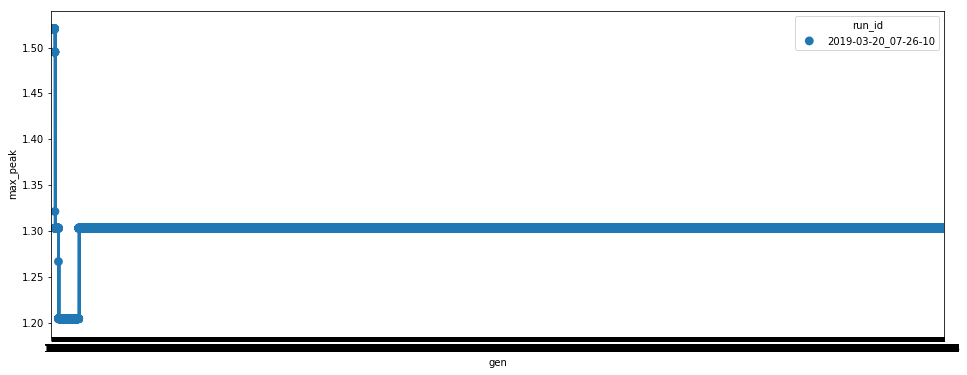

In [27]:
fig = plt.figure(figsize=(16,6))
on_x = 'gen'
on_y = 'max_peak'
sns.pointplot(x=on_x, y=on_y, data=generations_pop_df, hue="run_id", estimator=np.median, dodge=True);
plt.savefig(prepend_name + f'{on_x}-{on_y}.pdf');

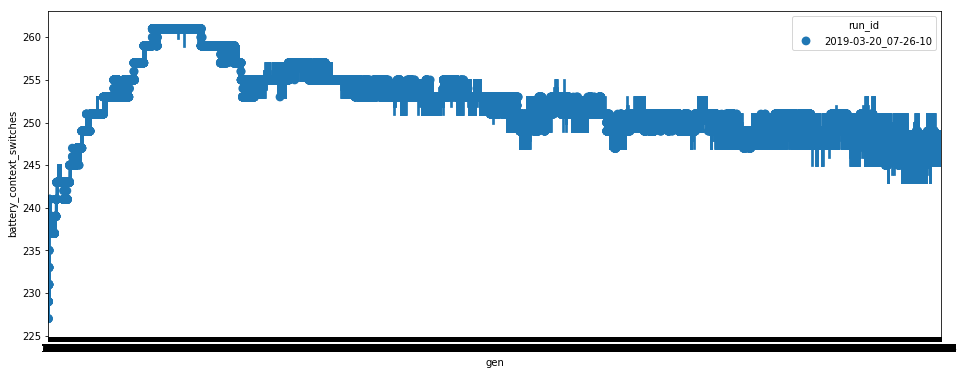

In [28]:
fig = plt.figure(figsize=(16,6))
on_x = 'gen'
on_y = 'battery_context_switches'
sns.pointplot(x=on_x, y=on_y, data=generations_pop_df, hue="run_id", estimator=np.median, dodge=True);
plt.savefig(prepend_name + f'{on_x}-{on_y}.pdf');